# 04. 基于GATv2在图分类（MUTAG-多图批训练）

在这里我们将更深入地了解如何将图神经网络（GNN）应用于图分类任务。图分类是指在给定图的数据集的情况下，基于一些结构图的属性对整个图（与节点相反）进行分类的问题。在这里，我们想要嵌入整个图，并且我们想要以这样一种方式嵌入这些图，即在给定手头的任务的情况下，它们是线性可分离的。

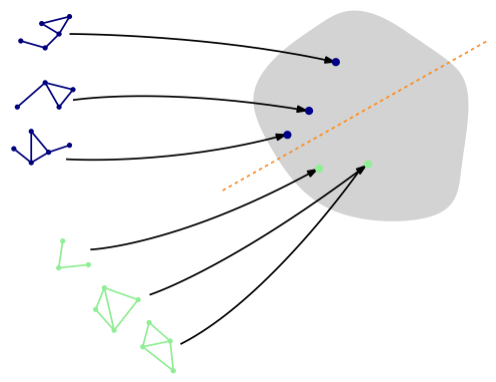

## 1. 数据集介绍

 图分类最常见的任务是分子性质预测，其中分子被表示为图，该任务可能是推断分子是否抑制HIV病毒复制。多特蒙德工业大学（The TU Dortmund University）收集了一系列不同的图分类数据集，称为TUDatasets，这些数据集也可以通过PyTorch Geometric中的torch_geometric.datasets.TUDataset 访问。让我们加载并检查其中一个较小的数据集，即MUTAG dataset：

In [5]:
import torch
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root='./datasets', name='MUTAG')


print(f'数据集: {dataset}')
print(f'数据集包含{len(dataset)}个图')
print(f'数据集特征数: {dataset.num_features}')
print(f'数据集类别数: {dataset.num_classes}')


数据集: MUTAG(188)
数据集包含188个图
数据集特征数: 7
数据集类别数: 2


In [6]:
# 获取第一个图对象
data = dataset[1]
print(data)

# 获取第一个图对象的统计数据
print(f'图的节点数: {data.num_nodes}')
print(f'图的边数: {data.num_edges}')
print(f'图的节点特征维度: {data.num_node_features}')
print(f'平均图的度数: {data.num_edges / data.num_nodes:.2f}')
print(f'是否存在孤立节点: {data.has_isolated_nodes()}')
print(f'是否存在自环: {data.has_self_loops()}')
print(f'是否无向图: {data.is_undirected()}')


Data(edge_index=[2, 28], x=[13, 7], edge_attr=[28, 4], y=[1])
图的节点数: 13
图的边数: 28
图的节点特征维度: 7
平均图的度数: 2.15
是否存在孤立节点: False
是否存在自环: False
是否无向图: True


In [7]:
print(data.x)
print(data.edge_index)
print(data.y)

tensor([[1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.]])
tensor([[ 0,  0,  1,  1,  2,  2,  2,  3,  3,  4,  4,  5,  5,  6,  6,  7,  7,  7,
          8,  8,  8,  9,  9, 10, 10, 10, 11, 12],
        [ 1,  9,  0,  2,  1,  3,  7,  2,  4,  3,  5,  4,  6,  5,  7,  2,  6,  8,
          7,  9, 10,  0,  8,  8, 11, 12, 10, 10]])
tensor([0])


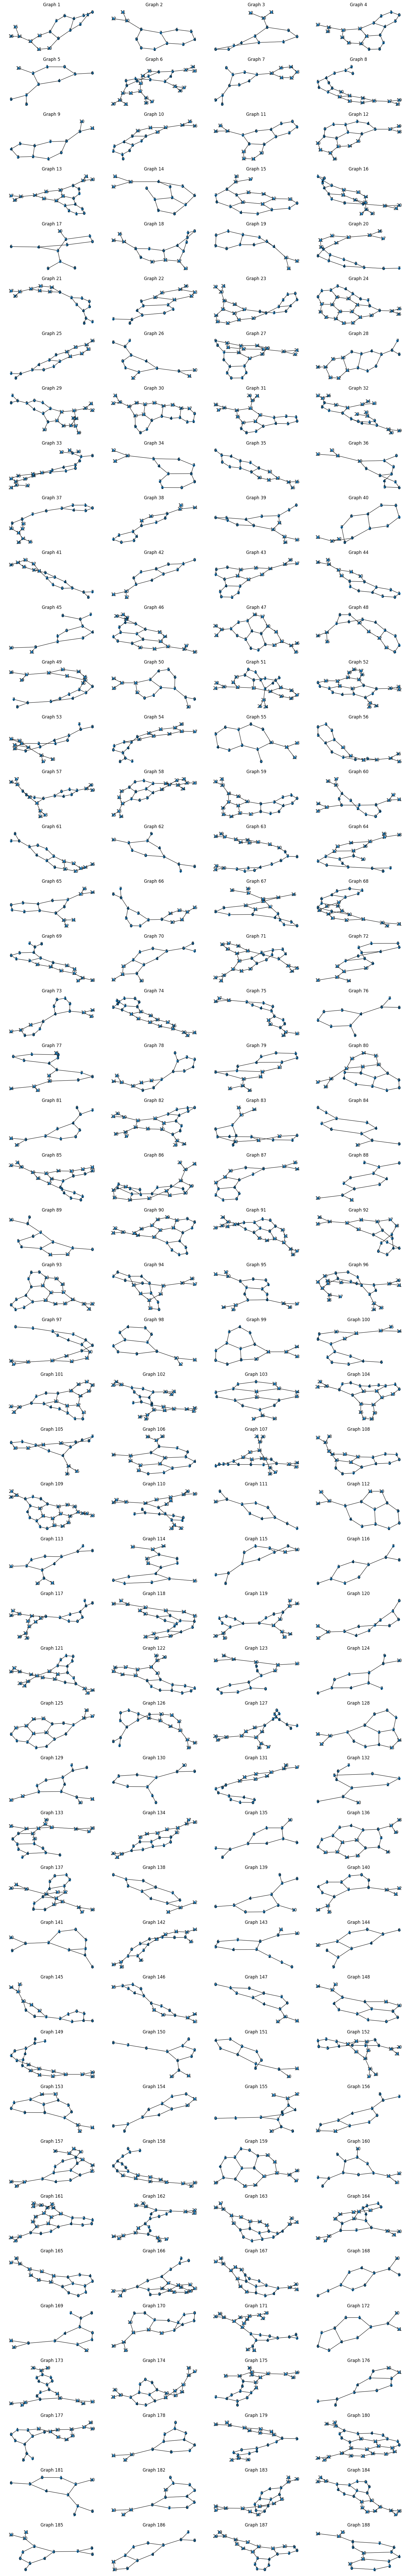

In [8]:
import networkx as nx
import matplotlib.pyplot as plt


# 创建一个图形窗口
fig, axes = plt.subplots(nrows=47, ncols=4, figsize=(16, 100))


# 在每个子图中绘制一个图
for i, data in enumerate(dataset):
    row, col = divmod(i, 4)
    G = nx.Graph()
    G.add_nodes_from(range(data.x.shape[0]))
    edge_index = data.edge_index.numpy()
    G.add_edges_from(edge_index.T)
    pos = nx.spring_layout(G)
    nx.draw(G, pos, ax=axes[row, col], with_labels=True, node_size=40)
    axes[row, col].set_title(f'Graph {i+1}')

plt.tight_layout()
plt.show()

 该数据集提供了188个不同的图，任务是将每个图分类为两类中的一类。        通过检查数据集的第一个图对象，我们可以看到它有17个节点（具有7维特征向量）和38条边（导致平均节点度为2.24）。它还只附带了一个图标签（y=[1]），并且除了以前的数据集之外，还提供了附加的4维边缘特征（edge_attr=[38，4]）。然而，为了简单起见，我们不会使用这些。        PyTorch Geometric为处理图形数据集提供了一些有用的实用程序，例如，我们可以对数据集进行打乱，并使用前150个图形作为训练图，同时使用其余的图形进行测试：

In [9]:
dataset = dataset.shuffle()

train_dataset = dataset[:128]
test_dataset = dataset[128:]

print(f'训练集包含{len(train_dataset)}个图')
print(f'测试集包含{len(test_dataset)}个图')


训练集包含128个图
测试集包含60个图


## 2. 数据集加载

由于图分类数据集中的图通常很小，因此一个好主意是在将图输入到图神经网络之前对图进行批处理，以确保GPU的充分利用。在图像或语言领域，此过程通常通过将每个示例重新缩放或填充为一组大小相等的形状来实现，然后将示例分组为附加维度。该维度的长度等于小批量中分组的示例数，通常称为batch_size。

然而，对于GNN，上述两种方法要么不可行，要么可能导致大量不必要的内存消耗。因此，PyTorch Geometric选择了另一种方法来实现跨多个示例的并行化。这里，邻接矩阵以对角线的方式堆叠（创建一个包含多个孤立子图的巨型图），节点和目标特征在节点维度中简单地连接：

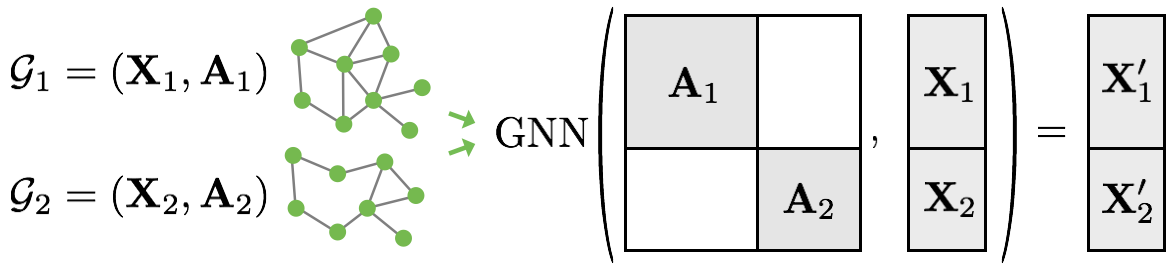


与其它batching程序相比，该程序具有一些关键优势：


1. 依赖于消息传递方案的GNN运算符不需要修改，因为属于不同图的两个节点之间不交换消息。

2. 没有计算或内存开销，因为邻接矩阵是以稀疏的方式保存的，只包含非零条目，即边缘。

 通过torch_geometric.data.DataLoader 类，PyTorch Geometric自动将多个图批处理为单个巨型图 ：

In [10]:
# 可视化
def visualize(data):
    G = nx.Graph()
    
    edge_index = data.edge_index.numpy()
    G.add_edges_from(edge_index.T)
    
    pos = nx.spring_layout(G)
    nx.draw(G, pos, font_weight='bold', node_size=10, node_color='lightblue', font_size=10)
    
    plt.figure(figsize=(600, 200))
    plt.tight_layout()
    plt.show()


Step 1:
当前batch中图的数量: 32
DataBatch(edge_index=[2, 1222], x=[553, 7], edge_attr=[1222, 4], y=[32], batch=[553], ptr=[33])



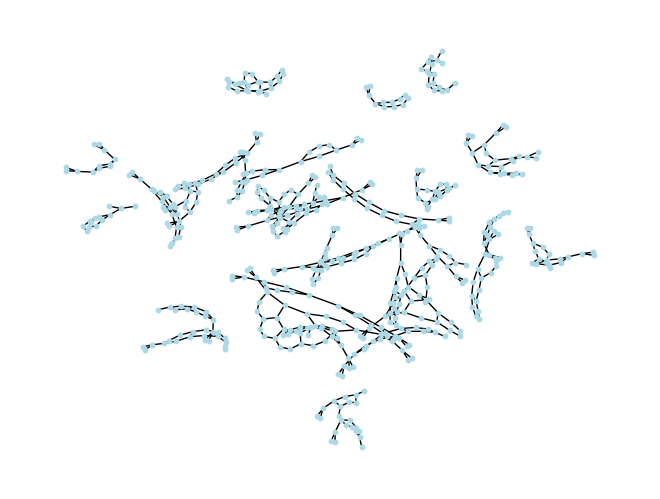

<Figure size 60000x20000 with 0 Axes>

Step 2:
当前batch中图的数量: 32
DataBatch(edge_index=[2, 1296], x=[588, 7], edge_attr=[1296, 4], y=[32], batch=[588], ptr=[33])



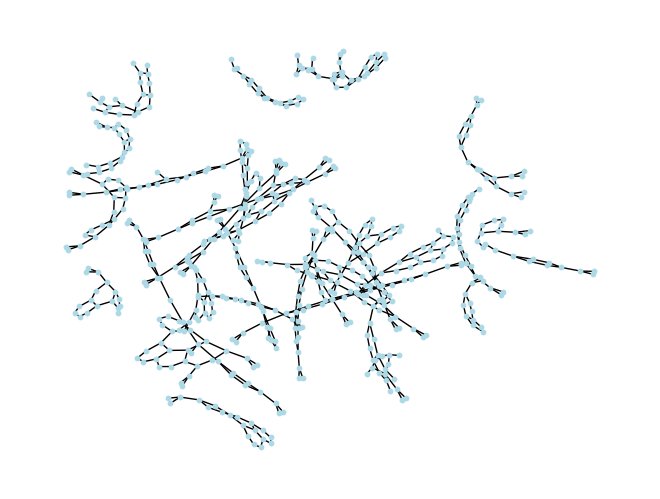

<Figure size 60000x20000 with 0 Axes>

Step 3:
当前batch中图的数量: 32
DataBatch(edge_index=[2, 1198], x=[547, 7], edge_attr=[1198, 4], y=[32], batch=[547], ptr=[33])



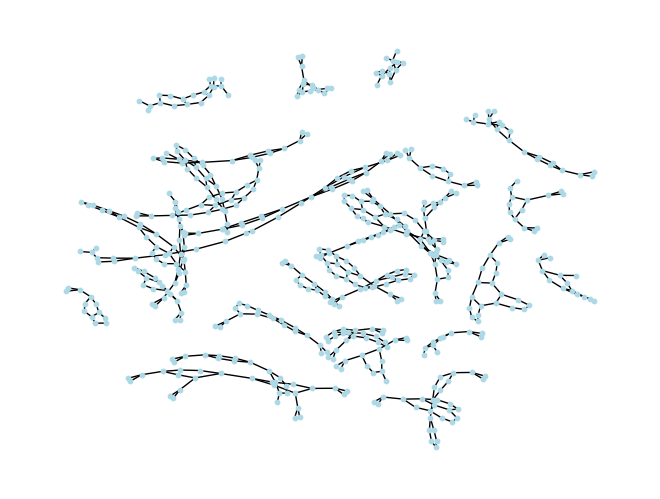

<Figure size 60000x20000 with 0 Axes>

Step 4:
当前batch中图的数量: 32
DataBatch(edge_index=[2, 1272], x=[578, 7], edge_attr=[1272, 4], y=[32], batch=[578], ptr=[33])



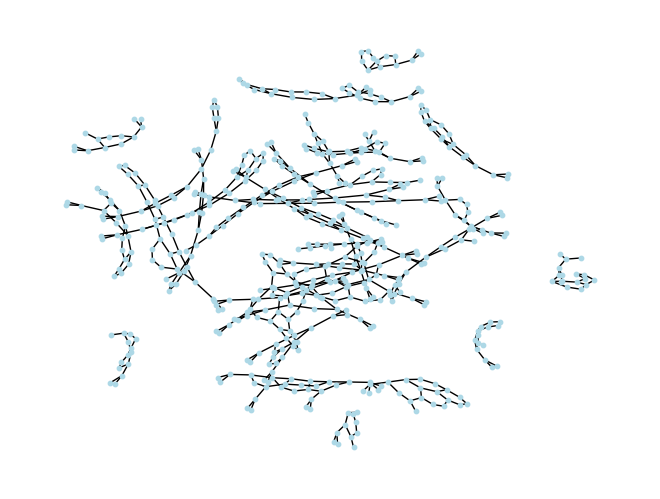

<Figure size 60000x20000 with 0 Axes>

In [11]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=' * 100)
    print(f'当前batch中图的数量: {data.num_graphs}')
    print(data)
    print()
    
    visualize(data)
    

## 3. 训练一个图神经网络(GNN)

训练用于图分类的GNN通常遵循一个简单的方案:

1. 通过执行多轮消息传递嵌入每个节点

2. 将节点嵌入聚合到统一图嵌入中（readout layer）

3. 在图嵌入上训练最终分类器

文献中存在多个readout layer，例如，mean、max、sum、加权和等。在这里，我们使用平均池化，因为它在实践中表现良好。

$$
\mathbf{x}_{\mathcal{G}} = \frac{1}{|\mathcal{V}|} \sum_{v \in \mathcal{V}} \mathbf{x}_v^{L}
$$





In [12]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv
from torch_geometric.nn import global_mean_pool

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class GATv2(nn.Module):
    def __init__(self, out_channels=2):
        super(GATv2, self).__init__()
        
        # 第一层
        self.conv1_1 = GATv2Conv(dataset.num_features, 128, heads=8, concat=False)
        self.conv1_2 = GATv2Conv(128, 128, heads=8, concat=False)
        
        # 第二层
        self.conv2_1 = GATv2Conv(128, 128, heads=8, concat=False)
        self.conv2_2 = GATv2Conv(128, 128, heads=8, concat=False)
        
        # 第三层
        self.conv3_1 = GATv2Conv(128, 128, heads=8, concat=False)
        self.conv3_2 = GATv2Conv(128, 32, heads=8, concat=False)
        
        self.classifier = nn.Linear(32, out_channels)
        
        
    def forward(self, x, edge_index, batch):
        # 第一层
        x = F.relu(self.conv1_1(x, edge_index))
        x1 = F.relu(self.conv1_2(x, edge_index))
        
        # 第二层 + 残差连接
        x = F.relu(self.conv2_1(x1, edge_index))
        x2 = F.relu(self.conv2_2(x, edge_index))
        x2 = x2 + x1  # 残差连接
        
        # 第三层 + 残差连接
        x = F.relu(self.conv3_1(x2, edge_index))
        x3 = F.relu(self.conv3_2(x, edge_index))
        
        # 全局平均池化
        x = global_mean_pool(x3, batch)  # [batch_size, 32]
        
        # 分类器
        x = F.dropout(x, p=0.4, training=self.training)
        x = self.classifier(x)
        
        return x
    
model = GATv2().to(device)
# 1. 打印模型结构
print(model)

# 2. 打印模型参数数量
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'\n可训练参数总数: {count_parameters(model):,}')

# 3. 测试一个批次的前向传播
batch_data = next(iter(train_loader))
batch_data = batch_data.to(device)
with torch.no_grad():
    output = model(batch_data.x, batch_data.edge_index, batch_data.batch)
print(f'\n输出形状: {output.shape}')


GATv2(
  (conv1_1): GATv2Conv(7, 128, heads=8)
  (conv1_2): GATv2Conv(128, 128, heads=8)
  (conv2_1): GATv2Conv(128, 128, heads=8)
  (conv2_2): GATv2Conv(128, 128, heads=8)
  (conv3_1): GATv2Conv(128, 128, heads=8)
  (conv3_2): GATv2Conv(128, 32, heads=8)
  (classifier): Linear(in_features=32, out_features=2, bias=True)
)

可训练参数总数: 1,145,314

输出形状: torch.Size([32, 2])


In [13]:
from torchinfo import summary


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_data = next(iter(train_loader))  # 获取第一个批次的数据
batch_data = batch_data.to(device)     # 移动到相应设备

summary(model, input_data=(batch_data.x, batch_data.edge_index, batch_data.batch))

Layer (type:depth-idx)                   Output Shape              Param #
GATv2                                    [32, 2]                   --
├─GATv2Conv: 1-1                         [581, 128]                1,152
│    └─Linear: 2-1                       [581, 1024]               8,192
│    └─Linear: 2-2                       [581, 1024]               8,192
│    └─SumAggregation: 2-3               [581, 8, 128]             --
├─GATv2Conv: 1-2                         [581, 128]                1,152
│    └─Linear: 2-4                       [581, 1024]               132,096
│    └─Linear: 2-5                       [581, 1024]               132,096
│    └─SumAggregation: 2-6               [581, 8, 128]             --
├─GATv2Conv: 1-3                         [581, 128]                1,152
│    └─Linear: 2-7                       [581, 1024]               132,096
│    └─Linear: 2-8                       [581, 1024]               132,096
│    └─SumAggregation: 2-9               [581, 8, 

In [24]:
import time
import torch.optim as optim
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.00001, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss(reduction='sum')  # 损失求和
Epochs = 1000


def train(loader):
    model.train()
    
    train_loss = 0.
    
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        train_out = model(data.x, data.edge_index, data.batch)
        loss = criterion(train_out, data.y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    return train_loss * 1. / len(loader.dataset)


def tess(loader):
    model.eval()
    
    correct = 0
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            test_out = model(data.x, data.edge_index, data.batch)
            preds = test_out.argmax(dim=1)
            correct += int((preds == data.y).sum())
        
    return correct * 1. / len(loader.dataset)


start_time = time.time()

for epoch in range(Epochs):
    train_loss = train(train_loader)
    train_acc = tess(train_loader)
    test_acc = tess(test_loader)
    if (epoch + 1) % 10 == 0:
        print(f'Epoch: {epoch+1}, Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
    
end_time = time.time()
print(f'Time: {end_time - start_time:.2f}s')

Epoch: 10, Loss: 0.0319, Train Acc: 1.0000, Test Acc: 0.7833
Epoch: 20, Loss: 0.0294, Train Acc: 1.0000, Test Acc: 0.7833
Epoch: 30, Loss: 0.0102, Train Acc: 1.0000, Test Acc: 0.7833
Epoch: 40, Loss: 0.0264, Train Acc: 1.0000, Test Acc: 0.7833
Epoch: 50, Loss: 0.0318, Train Acc: 1.0000, Test Acc: 0.7833
Epoch: 60, Loss: 0.0140, Train Acc: 1.0000, Test Acc: 0.7833
Epoch: 70, Loss: 0.0374, Train Acc: 1.0000, Test Acc: 0.7833
Epoch: 80, Loss: 0.0093, Train Acc: 1.0000, Test Acc: 0.7833
Epoch: 90, Loss: 0.0113, Train Acc: 1.0000, Test Acc: 0.7833
Epoch: 100, Loss: 0.0037, Train Acc: 1.0000, Test Acc: 0.7833
Epoch: 110, Loss: 0.0123, Train Acc: 1.0000, Test Acc: 0.7833
Epoch: 120, Loss: 0.0088, Train Acc: 1.0000, Test Acc: 0.7833
Epoch: 130, Loss: 0.0114, Train Acc: 1.0000, Test Acc: 0.7833
Epoch: 140, Loss: 0.0120, Train Acc: 1.0000, Test Acc: 0.7833
Epoch: 150, Loss: 0.0098, Train Acc: 1.0000, Test Acc: 0.7833
Epoch: 160, Loss: 0.0363, Train Acc: 1.0000, Test Acc: 0.7833
Epoch: 170, Loss: